# WORLD CUP QATAR-2022 FORECASTING USING MACHINE LEARNING

## 1. Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import pycountry_convert as pc
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error, classification_report, accuracy_score
from sklearn.multioutput import MultiOutputClassifier

## 2. Exploring some datesets to determine which would be better for the model

In [2]:
wcup = pd.read_csv(r'C:\Users\USUARIO\Documents\GitHub\Assorted-Projects\Datasets\WorldCUP\WorldCupMatches.csv')

In [3]:
wcup.head()

,Year,Datetime,Stage,Stadium,City,Home Team Name,Home Team Goals,Away Team Goals,Away Team Name,Win conditions,Attendance,Half-time Home Goals,Half-time Away Goals,Referee,Assistant 1,Assistant 2,RoundID,MatchID,Home Team Initials,Away Team Initials
0,1930.0,13 Jul 1930 - 15:00,Group 1,Pocitos,Montevideo,France,4.0,1.0,Mexico,,4444.0,3.0,0.0,LOMBARDI Domingo (URU),CRISTOPHE Henry (BEL),REGO Gilberto (BRA),201.0,1096.0,FRA,MEX
1,1930.0,13 Jul 1930 - 15:00,Group 4,Parque Central,Montevideo,USA,3.0,0.0,Belgium,,18346.0,2.0,0.0,MACIAS Jose (ARG),MATEUCCI Francisco (URU),WARNKEN Alberto (CHI),201.0,1090.0,USA,BEL
2,1930.0,14 Jul 1930 - 12:45,Group 2,Parque Central,Montevideo,Yugoslavia,2.0,1.0,Brazil,,24059.0,2.0,0.0,TEJADA Anibal (URU),VALLARINO Ricardo (URU),BALWAY Thomas (FRA),201.0,1093.0,YUG,BRA
3,1930.0,14 Jul 1930 - 14:50,Group 3,Pocitos,Montevideo,Romania,3.0,1.0,Peru,,2549.0,1.0,0.0,WARNKEN Alberto (CHI),LANGENUS Jean (BEL),MATEUCCI Francisco (URU),201.0,1098.0,ROU,PER
4,1930.0,15 Jul 1930 - 16:00,Group 1,Parque Central,Montevideo,Argentina,1.0,0.0,France,,23409.0,0.0,0.0,REGO Gilberto (BRA),SAUCEDO Ulises (BOL),RADULESCU Constantin (ROU),201.0,1085.0,ARG,FRA


In [4]:
wcup.head(3)

,Year,Datetime,Stage,Stadium,City,Home Team Name,Home Team Goals,Away Team Goals,Away Team Name,Win conditions,Attendance,Half-time Home Goals,Half-time Away Goals,Referee,Assistant 1,Assistant 2,RoundID,MatchID,Home Team Initials,Away Team Initials
0,1930.0,13 Jul 1930 - 15:00,Group 1,Pocitos,Montevideo,France,4.0,1.0,Mexico,,4444.0,3.0,0.0,LOMBARDI Domingo (URU),CRISTOPHE Henry (BEL),REGO Gilberto (BRA),201.0,1096.0,FRA,MEX
1,1930.0,13 Jul 1930 - 15:00,Group 4,Parque Central,Montevideo,USA,3.0,0.0,Belgium,,18346.0,2.0,0.0,MACIAS Jose (ARG),MATEUCCI Francisco (URU),WARNKEN Alberto (CHI),201.0,1090.0,USA,BEL
2,1930.0,14 Jul 1930 - 12:45,Group 2,Parque Central,Montevideo,Yugoslavia,2.0,1.0,Brazil,,24059.0,2.0,0.0,TEJADA Anibal (URU),VALLARINO Ricardo (URU),BALWAY Thomas (FRA),201.0,1093.0,YUG,BRA


In [5]:
oppo_list = glob.glob(r'C:\Users\USUARIO\Documents\GitHub\Assorted-Projects\Datasets\WorldCUP\archive\International_Football_History_Countries\*\Opponents_History.csv')

In [6]:
opponent_history = pd.DataFrame()

for i,path in enumerate(oppo_list):
    team = pd.read_csv(path)
    team['Main'] = oppo_list[i].split('\\')[10]
    opponent_history = pd.concat([opponent_history, team], axis=0)

In [7]:
opp_history = opponent_history[opponent_history.Squad != 'Squad']

In [8]:
opp_history.head()

,Squad,MP,W,D,L,GF,GA,GD,PPM,Head-to-Head,Main
0,cl Chile,19,11,7,1,30,13,+17,2.05,Head-to-Head,Argentina
1,uy Uruguay,17,11,3,3,27,15,+12,2.06,Head-to-Head,Argentina
2,br Brazil,17,5,4,8,15,26,-11,1.06,Head-to-Head,Argentina
3,bo Bolivia,16,11,3,2,41,16,+25,2.25,Head-to-Head,Argentina
4,co Colombia,16,8,6,2,20,10,+10,1.88,Head-to-Head,Argentina


In [9]:
ecu_wc = pd.read_csv(r'C:\Users\USUARIO\Documents\GitHub\Assorted-Projects\Datasets\WorldCUP\archive\International_Football_History_Countries\Ecuador\Worldcups_History.csv')
ecu_wc.head()

,Season,Squad,Comp,LgRank,MP,W,D,L,GF,GA,GD,Pts,Top Team Scorer,Goalkeeper,Notes
0,2022,Ecuador,1. FIFA World Cup,GR,0,0,0,0,0,0,0,0,NaN,NaN,NaN
1,2014,Ecuador,1. FIFA World Cup,GR,3,1,1,1,3,3,0,4,Enner Valencia - 3,Alexander Domínguez,NaN
2,2006,Ecuador,1. FIFA World Cup,R16,4,2,0,2,5,4,1,6,"Agustín Delgado, Carlos Tenorio - 2",Cristian Mora,NaN
3,2002,Ecuador,1. FIFA World Cup,GR,3,1,0,2,2,4,-2,3,"Agustín Delgado, Édison Méndez - 1",José Francisco Cevallos,NaN


### Dataset results could be better to predict matches head-head given the amount of data available

In [10]:
all_results = pd.read_csv(r'C:\Users\USUARIO\Documents\GitHub\Assorted-Projects\Datasets\WorldCUP\results.csv')
all_results.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0.0,0.0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4.0,2.0,Friendly,London,England,False
2,1874-03-07,Scotland,England,2.0,1.0,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2.0,2.0,Friendly,London,England,False
4,1876-03-04,Scotland,England,3.0,0.0,Friendly,Glasgow,Scotland,False


In [11]:
all_results.dropna(inplace=True)

In [12]:
all_results['date'] = pd.to_datetime(all_results.date, infer_datetime_format=True)

### One external feature which could help forecasting is the Ranking FIFA

In [13]:
ranking_fifa = pd.read_csv(r'C:\Users\USUARIO\Documents\GitHub\Assorted-Projects\Datasets\WorldCUP\fifa_ranking-2022-10-06.csv')

In [14]:
ranking_fifa['rank_date'] = pd.to_datetime(ranking_fifa.rank_date, infer_datetime_format=True)

In [15]:
ranking_fifa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63916 entries, 0 to 63915
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   rank             63916 non-null  int64         
 1   country_full     63916 non-null  object        
 2   country_abrv     63916 non-null  object        
 3   total_points     63916 non-null  float64       
 4   previous_points  63916 non-null  float64       
 5   rank_change      63916 non-null  int64         
 6   confederation    63916 non-null  object        
 7   rank_date        63916 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(2), object(3)
memory usage: 3.9+ MB


In [16]:
ranking_fifa['Year'] = pd.DatetimeIndex(ranking_fifa.rank_date).year

#### -  Since the competition does not match when FIFA Ranking is published, the average year will be taken into account

In [17]:
rank_avg_year = ranking_fifa.groupby(['Year', 'country_full']).mean()

In [18]:
rank_avg_year.reset_index(inplace=True)

In [19]:
rank_avg_year[rank_avg_year.country_full == 'Ecuador'].head()

,Year,country_full,rank,total_points,previous_points,rank_change
37,1992,Ecuador,65.0,23.0,0.0,0.0
186,1993,Ecuador,42.4,37.0,34.6,-3.4
343,1994,Ecuador,49.3,33.5,33.8,0.7
514,1995,Ecuador,60.5,32.6,32.1,0.0
692,1996,Ecuador,38.4,43.8,42.8,-2.2


In [20]:
all_results.date = pd.to_datetime(all_results.date, infer_datetime_format=True)

In [21]:
all_results['Year'] = pd.DatetimeIndex(all_results.date).year

In [22]:
all_results[all_results.home_team == 'Ecuador']

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,Year
2141,1938-08-11,Ecuador,Peru,1.0,9.0,Bolivarian Games,Bogotá,Colombia,True,1938
2148,1938-08-19,Ecuador,Venezuela,5.0,2.0,Bolivarian Games,Bogotá,Colombia,True,1938
2193,1939-01-22,Ecuador,Uruguay,0.0,6.0,Copa América,Lima,Peru,True,1939
2201,1939-02-12,Ecuador,Paraguay,1.0,3.0,Copa América,Lima,Peru,True,1939
2340,1941-02-09,Ecuador,Uruguay,0.0,6.0,Copa América,Santiago,Chile,True,1941
...,...,...,...,...,...,...,...,...,...,...
43391,2022-01-27,Ecuador,Brazil,1.0,1.0,FIFA World Cup qualification,Quito,Ecuador,False,2022
43556,2022-03-29,Ecuador,Argentina,1.0,1.0,FIFA World Cup qualification,Guayaquil,Ecuador,False,2022
43660,2022-06-02,Ecuador,Nigeria,1.0,0.0,Friendly,Harrison,United States,True,2022
43850,2022-06-11,Ecuador,Cape Verde,1.0,0.0,Friendly,Fort Lauderdale,United States,True,2022


#### - Merging both Datasets Ranking_fifa and All_Results

In [23]:
results_rank = pd.merge(all_results, rank_avg_year, how='left', left_on=['home_team','Year'], right_on=['country_full','Year'])

In [24]:
results_rank.rename(columns={'rank':'home_rank','total_points':'home_points'}, inplace=True)
# Drop columns that are not useful anymore 
results_rank.drop(columns=['city','country_full','previous_points','rank_change'], axis=1, inplace=True)

In [25]:
results_rank = pd.merge(results_rank, rank_avg_year, how='left', left_on=['away_team','Year'], right_on=['country_full','Year'])

In [26]:
results_rank.rename(columns={'rank':'away_rank','total_points':'away_points'}, inplace=True)
# Drop columns that are not useful anymore 
results_rank.drop(columns=['country_full','previous_points','rank_change'], axis=1, inplace=True)

In [27]:
results_rank.sort_values(by=['home_team','date'], inplace=True)

In [28]:
result_rank = results_rank.reset_index(drop=True)

In [29]:
# Populate NA values
results_rank.fillna(method='bfill', inplace=True)

In [30]:
# Drop NA values
results_rank.dropna(inplace=True)

In [31]:
results_rank.reset_index(drop=True, inplace=True)

In [32]:
results_rank[['home_rank','home_points','away_rank','away_points']] = results_rank[['home_rank','home_points','away_rank','away_points']].astype(int)

In [33]:
# Code the result as 2 = home_team wins, 1 = tie, 0 = home_team loses
result = []
for row in range(len(results_rank)):
    if results_rank.home_score[row] == results_rank.away_score[row]:
        result.append(1)
    
    elif results_rank.home_score[row] > results_rank.away_score[row]:
        result.append(2)

    else: 
        result.append(0)

In [34]:
results_rank['result'] = result

In [35]:
# Replace unknown-code country
results_rank.country.replace({'England':'United Kingdom','Wales':'United Kingdom', 'Western Samoa':'Samoa', 'China PR':'China'
,'Netherlands Guyana':'Guyana', 'Netherlands Antilles':'Haiti', 'Antilles':'Haiti','Vietnam Republic':'Vietnam', 'Soviet Union':'Russia',
'British Guyana':'Guyana','Dahomey':'Suriname','Surinam':'Suriname','Upper Volta':'Nigeria', 'Yugoslavia':'Czech Republic','Malaya':'Malaysia',
'Sint Maarten':'Haiti','Manchuria':'China','Burma':'Myanmar', 'Vietnam DR':'Vietnam', 'Zaïre':'Congo', 'Scotland':'United Kingdom',
'Bohemia':'Czech Republic', 'Czechoslovakia':'Czech Republic','Bohemia and Moravia':'Czech Republic','Belgian Congo':'Congo','DR Congo':'Congo'
,'French Somaliland':'Congo', 'United Arab Republic':'Egypt', 'Lautoka':'Fiji','German DR':'Germany','Gold Coast':'Australia',
'Northern Rhodesia':'Egypt', 'Portuguese Guinea':'Guinea', 'Ceylon':'Sri Lanka','Tanganyika':'Tanzania', 'Zanzibar':'Tanzania',
'Kosovo':'Russia','Nyasaland':'Malawi', 'Mali Federation':'Mali','Northern Ireland':'Ireland','Irish Free State':'Ireland','Éire':'Ireland', 
'Republic of Ireland':'Ireland', 'Saarland':'Germany', 'Serbia and Montenegro':'Serbia','Tahiti':'New Zealand','East Timor':'Indonesia',
'New Hebrides':'New Zealand','Yemen AR':'Yemen','Yemen DPR':'Yemen', 'Southern Rhodesia':'Congo','Rhodesia':'Congo'}, inplace=True)

#### - Mapping continents where the games took place

In [36]:
continent_dict = {}

for country in results_rank.country.unique():
    country_code = pc.country_name_to_country_alpha2(country, cn_name_format='default')
    conti_code = pc.country_alpha2_to_continent_code(country_code)
    continent_dict[country] = conti_code

In [37]:
results_rank['continent'] = results_rank.country.map(continent_dict)

In [38]:
all_games_results = results_rank.copy()

In [39]:
all_games_results.drop(columns=['home_score', 'away_score','country'], axis=1, inplace=True)

In [40]:
all_games_results.head()

,date,home_team,away_team,tournament,neutral,Year,home_rank,home_points,away_rank,away_points,result,continent
0,2012-09-25,Abkhazia,Artsakh,Friendly,False,2012,199,42,127,349,1,AS
1,2014-06-01,Abkhazia,Occitania,CONIFA World Football Cup,True,2014,199,42,127,349,1,EU
2,2014-06-04,Abkhazia,South Ossetia,CONIFA World Football Cup,True,2014,199,42,127,349,1,EU
3,2014-06-07,Abkhazia,Occitania,CONIFA World Football Cup,True,2014,199,42,127,349,0,EU
4,2016-05-29,Abkhazia,Chagos Islands,CONIFA World Football Cup,False,2016,199,42,127,349,2,AS


In [41]:
all_games_results.set_index([all_games_results.index,'date'], inplace=True)

#### - Differentiate FIFA World Cup Games from other Tournaments and Friendly Games 

In [42]:
tournament_dict = {'FIFA World Cup':1}

In [43]:
all_games_results['wcup_games'] = all_games_results.tournament.map(tournament_dict)

In [44]:
all_games_results.fillna(0, inplace=True)

In [45]:
all_games_results['wcup_games'] = all_games_results['wcup_games'].astype(int)

#### - Encode all object variables into numbers

In [46]:
country_dict = {}

for i, country in enumerate(sorted(list(set(pd.concat([all_games_results.home_team, all_games_results.away_team], axis=0))))):
    country_dict[country] = i

In [47]:
inv_country = {x:i for i, x in country_dict.items()}

In [48]:
all_games_results['home_code'] = all_games_results.home_team.map(country_dict)
all_games_results['away_code'] = all_games_results.away_team.map(country_dict)

In [49]:
all_games_results['neutral'] = all_games_results['neutral'].astype(int)

In [50]:
all_games_results['continent'] = all_games_results['continent'].astype('category').cat.codes

In [51]:
all_games_code = all_games_results.copy()

In [52]:
# Drop categorical variables
all_games_code.drop(['home_team','away_team','tournament'], axis=1, inplace=True)

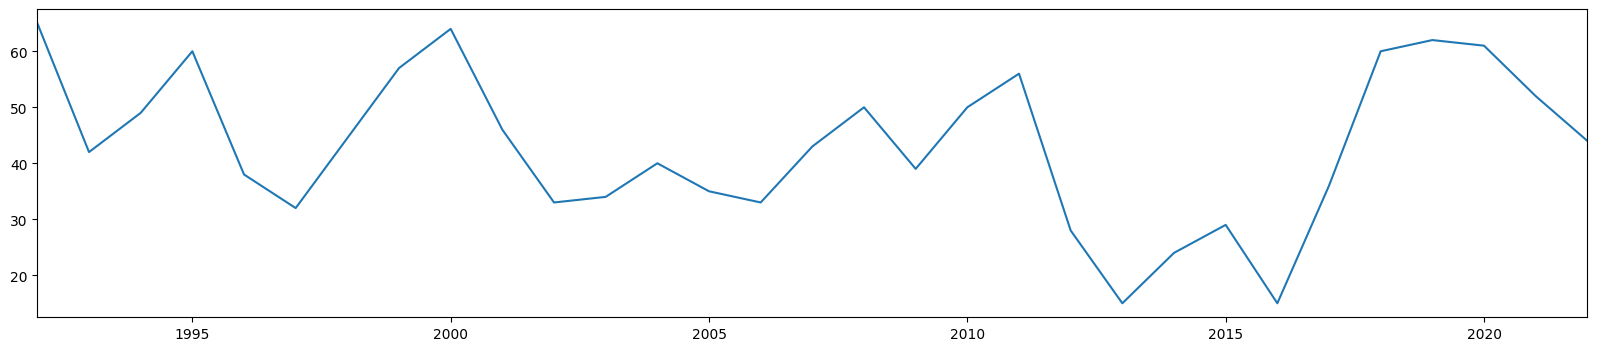

In [53]:
fig, ax = plt.subplots(figsize=(20,4))
ax.plot(all_games_results[all_games_results.home_team == 'Ecuador']['Year'], all_games_results[all_games_results.home_team == 'Ecuador']['home_rank'])
ax.set_xlim(1992,2022)
plt.show()

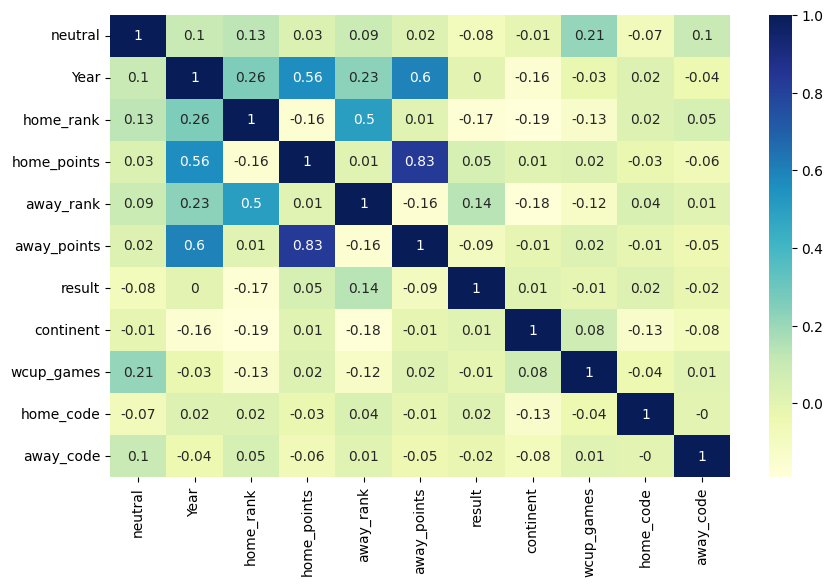

In [54]:
fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(round(all_games_code.corr(),2), cmap="YlGnBu", annot=True);

In [55]:
all_games_code_f = all_games_code[all_games_code.Year >= 2010]

## 4. Split dataset into training and validation sets

In [56]:
Y = all_games_code_f.result
X = all_games_code_f.drop('result', axis=1)

In [57]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.25, random_state=82)

## 5. Preprocessing Data

In [58]:
scaler = StandardScaler()
X_train_s = pd.DataFrame(scaler.fit_transform(X_train))
X_valid_s = pd.DataFrame(scaler.transform(X_valid))

In [59]:
Y_train.value_counts()

2    4293
0    2528
1    2071
Name: result, dtype: int64

## 6. Modeling using XGBoost and Random Forest

### Random Forest

In [60]:
model_rf = RandomForestClassifier(max_depth=5, n_estimators=1000, criterion='entropy')
model_rf = model_rf.fit(X_train, Y_train)

In [61]:
Y_pred = model_rf.predict(X_valid)

In [62]:
print(classification_report(Y_valid, Y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.58      0.41      0.48       871
           1       0.00      0.00      0.00       714
           2       0.54      0.91      0.67      1379

    accuracy                           0.55      2964
   macro avg       0.37      0.44      0.39      2964
weighted avg       0.42      0.55      0.46      2964



In [63]:
print(accuracy_score(Y_valid, Y_pred))

0.5452091767881242


### XGBoost

In [427]:
model_xgb = XGBClassifier(learning_rate=0.1, n_estimators=1000, max_depth=3, subsample=0.8, colsample_bytree=0.8, 
objective= 'multi:softprob', nthread=4, seed=27)

model_xgb = model_xgb.fit(X_train, Y_train, eval_set=[(X_train, Y_train),(X_valid, Y_valid)], verbose=200)

[0]	validation_0-mlogloss:1.07815	validation_1-mlogloss:1.07978
[200]	validation_0-mlogloss:0.83643	validation_1-mlogloss:0.92274
[400]	validation_0-mlogloss:0.78165	validation_1-mlogloss:0.92621
[600]	validation_0-mlogloss:0.73853	validation_1-mlogloss:0.93577
[800]	validation_0-mlogloss:0.70151	validation_1-mlogloss:0.94364
[999]	validation_0-mlogloss:0.67004	validation_1-mlogloss:0.95102


In [428]:
Y_pred = model_xgb.predict(X_valid)

In [429]:
print(accuracy_score(Y_valid, Y_pred))

0.5566801619433198


In [67]:
print(classification_report(Y_valid, Y_pred))

              precision    recall  f1-score   support

           0       0.56      0.53      0.55       871
           1       0.32      0.14      0.20       714
           2       0.60      0.79      0.68      1379

    accuracy                           0.56      2964
   macro avg       0.49      0.49      0.47      2964
weighted avg       0.52      0.56      0.52      2964



#### WORLD CUP Groups Stage

In [361]:
wcup_fixture = pd.read_excel(r'C:\Users\USUARIO\Documents\GitHub\Assorted-Projects\Datasets\WorldCUP\wcup_template.xlsx',sheet_name='group')

In [362]:
wcup_fixture['continent'] = wcup_fixture.continent.replace({'AS':1})
wcup_fixture['home_code'], wcup_fixture['away_code'] = wcup_fixture.home_code.map(country_dict), wcup_fixture.away_code.map(country_dict)

In [363]:
X_test = wcup_fixture.set_index('group')

In [364]:
Y_pred = model_xgb.predict(X_test)

In [365]:
wcup_fixture['Predi_Home'] = Y_pred

In [366]:
wcup_fixture['Predi_Home'].replace({2:3}, inplace=True)

In [367]:
wcup_fixture['Predi_away'] = wcup_fixture['Predi_Home'].replace({3:0,1:1,0:3},)

In [368]:
# Making 1 column to sum up the points
wcup_groups = pd.concat([wcup_fixture[['group','home_code', 'Predi_Home']], 
wcup_fixture[['group','away_code', 'Predi_away']].rename(columns={'away_code':'home_code', 'Predi_away':'Predi_Home'})])

In [369]:
wcup_class = wcup_groups.groupby(['group','home_code']).sum().reset_index()
wcup_class = wcup_class.sort_values(['group','Predi_Home'], ascending =[True, False])

In [370]:
group_class = wcup_class.reset_index(drop=True)

In [371]:
wcup_class['home_code'] = wcup_class['home_code'].astype(int)
wcup_class['home_code'] = wcup_class['home_code'].map(inv_country) 

#### WORLD CUP Round of 16

In [372]:
wcup_r16 = pd.read_excel(r'C:\Users\USUARIO\Documents\GitHub\Assorted-Projects\Datasets\WorldCUP\wcup_template.xlsx',sheet_name='r16')

In [373]:
# Arrange the matches regarding the fixture
wcup_r16.at[0,'home_code'] = group_class.at[0,'home_code'] 
wcup_r16.at[0,'away_code'] = group_class.at[5,'home_code']
wcup_r16.at[1,'home_code'] = group_class.at[1,'home_code'] 
wcup_r16.at[1,'away_code'] = group_class.at[4,'home_code']
wcup_r16.at[2,'home_code'] = group_class.at[8,'home_code'] 
wcup_r16.at[2,'away_code'] = group_class.at[13,'home_code']
wcup_r16.at[3,'home_code'] = group_class.at[9,'home_code'] 
wcup_r16.at[3,'away_code'] = group_class.at[12,'home_code']
wcup_r16.at[4,'home_code'] = group_class.at[16,'home_code'] 
wcup_r16.at[4,'away_code'] = group_class.at[21,'home_code']
wcup_r16.at[5,'home_code'] = group_class.at[17,'home_code'] 
wcup_r16.at[5,'away_code'] = group_class.at[20,'home_code']
wcup_r16.at[6,'home_code'] = group_class.at[24,'home_code'] 
wcup_r16.at[6,'away_code'] = group_class.at[29,'home_code']
wcup_r16.at[7,'home_code'] = group_class.at[25,'home_code'] 
wcup_r16.at[7,'away_code'] = group_class.at[28,'home_code'] 

In [374]:
wcup_r16[['home_code','away_code']] = wcup_r16[['home_code','away_code']].astype(int) 

In [375]:
# Making the ranks and points dictionaries
rank_dict = {}
points_dict = {}

for country, rank in zip(wcup_fixture['home_code'],wcup_fixture['home_rank']):
   rank_dict[country] = rank

for country, points in zip(wcup_fixture['home_code'],wcup_fixture['home_points']):
   points_dict[country] = points

In [376]:
# Map the rank and points of each country rigth after the WORLD CUP
wcup_r16['home_rank'] = (wcup_r16.home_code.astype(int)).map(rank_dict)
wcup_r16['away_rank'] = (wcup_r16.away_code.astype(int)).map(rank_dict)
wcup_r16['home_points'] = (wcup_r16.home_code.astype(int)).map(points_dict)
wcup_r16['away_points'] = (wcup_r16.away_code.astype(int)).map(points_dict)
wcup_r16['continent'] = wcup_r16.continent.replace({'AS':1})

In [377]:
Y_r16_pred =model_rf.predict(wcup_r16)

In [378]:
wcup_r16['Predi_home'] =  Y_r16_pred
wcup_r16['Predi_away'] = wcup_r16['Predi_home'].replace({2:0,1:1,0:2})

In [379]:
wcup_r16_class = pd.concat([wcup_r16[['home_code', 'Predi_home']], 
wcup_r16[['away_code', 'Predi_away']].rename(columns={'away_code':'home_code', 'Predi_away':'Predi_home'})])
wcup_r16_class = wcup_r16_class[wcup_r16_class.Predi_home == 2].sort_index()

#### WORLD CUP Round of 8

In [380]:
wcup_r8 = pd.read_excel(r'C:\Users\USUARIO\Documents\GitHub\Assorted-Projects\Datasets\WorldCUP\wcup_template.xlsx',sheet_name='r8')

In [381]:
wcup_r8.at[0,'home_code'] = wcup_r16_class.at[0,'home_code'] 
wcup_r8.at[0,'away_code'] = wcup_r16_class.at[2,'home_code']
wcup_r8.at[1,'home_code'] = wcup_r16_class.at[1,'home_code'] 
wcup_r8.at[1,'away_code'] = wcup_r16_class.at[3,'home_code']
wcup_r8.at[2,'home_code'] = wcup_r16_class.at[4,'home_code'] 
wcup_r8.at[2,'away_code'] = wcup_r16_class.at[6,'home_code']
wcup_r8.at[3,'home_code'] = wcup_r16_class.at[5,'home_code'] 
wcup_r8.at[3,'away_code'] = wcup_r16_class.at[7,'home_code']

In [382]:
wcup_r8[['home_code','away_code']] = wcup_r8[['home_code','away_code']].astype(int)
wcup_r8['home_rank'] = wcup_r8.home_code.map(rank_dict)
wcup_r8['away_rank'] = wcup_r8.away_code.map(rank_dict)
wcup_r8['home_points'] = wcup_r8.home_code.map(points_dict)
wcup_r8['away_points'] = wcup_r8.away_code.map(points_dict)
wcup_r8['continent'] = wcup_r8.continent.replace({'AS':1})

In [383]:
Y_r8_pred = model_rf.predict(wcup_r8)

In [384]:
wcup_r8['Predi_home'] = Y_r8_pred
wcup_r8['Predi_away'] = wcup_r8['Predi_home'].replace({2:0,1:1,0:2})

In [385]:
wcup_r8_class = pd.concat([wcup_r8[['home_code', 'Predi_home']], 
wcup_r8[['away_code', 'Predi_away']].rename(columns={'away_code':'home_code', 'Predi_away':'Predi_home'})])
wcup_r8_class = wcup_r8_class[wcup_r8_class.Predi_home == 2].sort_index()

#### WORLD CUP Semifinals

In [386]:
wcup_semi = pd.read_excel(r'C:\Users\USUARIO\Documents\GitHub\Assorted-Projects\Datasets\WorldCUP\wcup_template.xlsx',sheet_name='semi')

In [387]:
wcup_semi.at[0,'home_code'] = wcup_r8_class.at[0,'home_code'] 
wcup_semi.at[0,'away_code'] = wcup_r8_class.at[1,'home_code']
wcup_semi.at[1,'home_code'] = wcup_r8_class.at[2,'home_code'] 
wcup_semi.at[1,'away_code'] = wcup_r8_class.at[3,'home_code']

In [388]:
wcup_semi[['home_code','away_code']] = wcup_semi[['home_code','away_code']].astype(int)
wcup_semi['home_rank'] = wcup_semi.home_code.map(rank_dict)
wcup_semi['away_rank'] = wcup_semi.away_code.map(rank_dict)
wcup_semi['home_points'] = wcup_semi.home_code.map(points_dict)
wcup_semi['away_points'] = wcup_semi.away_code.map(points_dict)
wcup_semi['continent'] = wcup_semi.continent.replace({'AS':1})

In [389]:
Y_semi_pred = model_rf.predict(wcup_semi)
wcup_semi['Predi_home'] = Y_semi_pred
wcup_semi['Predi_away'] = wcup_semi['Predi_home'].replace({2:0,1:1,0:2})

In [390]:
wcup_semi_class = pd.concat([wcup_semi[['home_code', 'Predi_home']], 
wcup_semi[['away_code', 'Predi_away']].rename(columns={'away_code':'home_code', 'Predi_away':'Predi_home'})])
wcup_semi_class = wcup_semi_class[wcup_semi_class.Predi_home == 2].sort_index()

#### WORLD CUP Finals

In [391]:
wcup_final = pd.read_excel(r'C:\Users\USUARIO\Documents\GitHub\Assorted-Projects\Datasets\WorldCUP\wcup_template.xlsx',sheet_name='final')

In [392]:
wcup_final.at[0,'home_code'] = wcup_semi_class.at[0,'home_code'] 
wcup_final.at[0,'away_code'] = wcup_semi_class.at[1,'home_code']

In [393]:
wcup_final[['home_code','away_code']] = wcup_final[['home_code','away_code']].astype(int)
wcup_final['home_rank'] = wcup_final.home_code.map(rank_dict)
wcup_final['away_rank'] = wcup_final.away_code.map(rank_dict)
wcup_final['home_points'] = wcup_final.home_code.map(points_dict)
wcup_final['away_points'] = wcup_final.away_code.map(points_dict)
wcup_final['continent'] = wcup_final.continent.replace({'AS':1})

In [394]:
Y_final_pred = model_rf.predict(wcup_final)
wcup_final['Predi_home'] = Y_final_pred
wcup_final['Predi_away'] = wcup_final['Predi_home'].replace({2:0,1:1,0:2})

##### Mapping country codes with country names

In [396]:
wcup_r16['home_code'] = wcup_r16.home_code.map(inv_country)
wcup_r16['away_code'] = wcup_r16.away_code.map(inv_country)


In [397]:
wcup_r8['home_code'] = wcup_r8.home_code.map(inv_country)
wcup_r8['away_code'] = wcup_r8.away_code.map(inv_country)


In [398]:
wcup_semi['home_code'] = wcup_semi.home_code.map(inv_country)
wcup_semi['away_code'] = wcup_semi.away_code.map(inv_country)

In [399]:
wcup_final['home_code'] = wcup_final.home_code.map(inv_country)
wcup_final['away_code'] = wcup_final.away_code.map(inv_country)

##### Prediction results all around the competition

In [402]:
wcup_class.groupby(['group','home_code']).sum()

Predi_Home
group home_code                
0     Ecuador                 0
      Netherlands             9
      Qatar                   3
      Senegal                 6
1     England                 9
      Iran                    1
      United States           6
      Wales                   1
2     Argentina               6
      Mexico                  6
      Poland                  6
      Saudi Arabia            0
3     Australia               3
      Denmark                 6
      France                  6
      Tunisia                 3
4     Costa Rica              3
      Germany                 4
      Japan                   3
      Spain                   7
5     Belgium                 9
      Canada                  1
      Croatia                 4
      Morocco                 3
6     Brazil                  6
      Cameroon                0
      Serbia                  3
      Switzerland             9
7     Ghana                   0
      Portugal                6
      South Korea             3
      Uruguay                 9

In [414]:
wcup_r16[['Predi_home','Predi_away']] = wcup_r16[['Predi_home','Predi_away']].replace({2:'Winner', 0:'-'})
wcup_r16

,neutral,Year,home_rank,home_points,away_rank,away_points,continent,wcup_games,home_code,away_code,Predi_home,Predi_away
0,1,2022,10,1658,15,1633,1,1,Netherlands,United States,Winner,-
1,1,2022,20,1584,5,1761,1,1,Senegal,England,-,Winner
2,1,2022,4,1765,3,1789,1,1,Argentina,France,-,Winner
3,1,2022,9,1658,11,1653,1,1,Mexico,Denmark,-,Winner
4,1,2022,7,1709,16,1621,1,1,Spain,Croatia,Winner,-
5,1,2022,12,1650,2,1827,1,1,Germany,Belgium,-,Winner
6,1,2022,14,1635,8,1674,1,1,Switzerland,Portugal,-,Winner
7,1,2022,1,1832,13,1635,1,1,Brazil,Uruguay,Winner,-


In [431]:
wcup_r8[['Predi_home','Predi_away']] = wcup_r8[['Predi_home','Predi_away']].replace({2:'Winner', 0:'-'})
wcup_r8

,neutral,Year,home_rank,home_points,away_rank,away_points,continent,wcup_games,home_code,away_code,Predi_home,Predi_away
0,1,2022,10,1658,3,1789,1,1,Netherlands,France,-,Winner
1,1,2022,5,1761,11,1653,1,1,England,Denmark,Winner,-
2,1,2022,7,1709,8,1674,1,1,Spain,Portugal,Winner,-
3,1,2022,2,1827,1,1832,1,1,Belgium,Brazil,-,Winner


In [416]:
wcup_semi[['Predi_home','Predi_away']] = wcup_semi[['Predi_home','Predi_away']].replace({2:'Winner', 0:'-'})
wcup_semi

,neutral,Year,home_rank,home_points,away_rank,away_points,continent,wcup_games,home_code,away_code,Predi_home,Predi_away
0,1,2022,3,1789,5,1761,1,1,France,England,-,Winner
1,1,2022,7,1709,1,1832,1,1,Spain,Brazil,-,Winner


In [417]:
wcup_final[['Predi_home','Predi_away']] = wcup_final[['Predi_home','Predi_away']].replace({2:'Winner', 0:'-'})
wcup_final

,neutral,Year,home_rank,home_points,away_rank,away_points,continent,wcup_games,home_code,away_code,Predi_home,Predi_away
0,1,2022,5,1761,1,1832,1,1,England,Brazil,-,Winner
